# Purpose:
### Run every algorithm + filter over the data, find the one that maximizes precision

## Imports

In [33]:
import numpy as np # need this for basically everything
import matplotlib.pyplot as plt # plotting
import numba as nb # numba compiles to fast c code
from numba import jit
import scipy; from scipy import signal # savitzky-golay filter
import time # time results
# use cartesian product to make nested for loops its own iterator
#  I know it's janky, but it enables fast parallelism 
from itertools import product  
from multiprocess import Pool # parallelism
import pickle

In [2]:
wavelen = 3500
%load_ext Cython

### Noise Generation

Right now using gaussian with np.random.normal

In [3]:
def superimpose_noise(wf, stdDev):
    length=len(wf)
    fin = open('power_spectrum.dat', 'r')
    powerspectrum = array(str(fin.read()).split(), dtype=float64)
    fin.close()
    my_array = zeros((65533,2))
    my_array[0][0]= -114.962
    my_array[0][0]= 0.
    for i in range(1,32767):
        phase = 2.*pi*(random.randint(1, 10000000 + 1)%10000000)/10000000.
        my_array[i][0]=powerspectrum[i-1]*cos(phase);
        my_array[65532-i+1][0]=my_array[i][0]
        my_array[i][1]=powerspectrum[i-1]*sin(phase);
        my_array[65532-i+1][1]= -1*(my_array[i][1])
    my_array = (my_array[:,0]+my_array[:,1].astype(complex_))
    my_array = fft.irfft(my_array)
    for i in range(length):
        wf[i]= length*stdDev*my_array[i]*1.633953736 # adjusted factor here since fftw3 is unnormalized fft
    return

### Waveform Generation

In [4]:
@jit(nopython=True, parallel=True, nogil=True)
def dataGen(amp, T0):
    wf = np.empty(3500)
    length = len(wf)
    cc_slow = 2.5+0.4*np.random.normal(); cc_slow=cc_slow/(cc_slow+1); ##charge collection slow time constant

    cc_fast = 1./2.5; #charge collection fast time constant
    alpha_cr = 1250./(1250.+1.); #fall time of output
    alpha_rc1 = 1./2.75;
    alpha_rc2 = 1./2.75;
    step=np.zeros(2);charge=np.zeros(2);cur_s=np.zeros(2);cur_f=np.zeros(2);cr=np.zeros(2);rc1=np.zeros(2);rc2=np.zeros(2);
    for i in range(length):
        if i>=T0:
            step[i%2]=1.
        else:
            step[i%2]=0.
        cur_s[i%2]=cc_slow*(cur_s[(i+1)%2]+step[i%2]-step[(i+1)%2]);
        cur_f[i%2]=cc_fast*(cur_s[i%2]-cur_f[(i+1)%2])+cur_f[(i+1)%2];
        charge[i%2]=charge[(i+1)%2]+amp*cur_f[i%2]*(1./cc_slow-1.);
        cr[i%2]=alpha_cr*(cr[(i+1)%2]+charge[i%2]-charge[(i+1)%2]);
        rc1[i%2]=alpha_rc1*(cr[i%2]-rc1[(i+1)%2])+rc1[(i+1)%2];
        rc2[i%2]=alpha_rc2*(rc1[i%2]-rc2[(i+1)%2])+rc2[(i+1)%2];
        wf[i]=rc2[i%2];
    return wf

In [5]:
@jit(nopython=True, nogil=True, locals={'wavelen':nb.typeof(wavelen), 'dataGen':nb.typeof(dataGen)})
def NdataGen(N, amp, T0s):
    X = np.empty((N, wavelen))
    for i in range(N):
        X[i] = dataGen(amp, T0s[i])
        for j in range(wavelen):
            X[i][j] = X[i][j] + np.random.normal()*20
    return X

In [6]:
wfs = NdataGen(10, 100, np.ones(10)*1000)

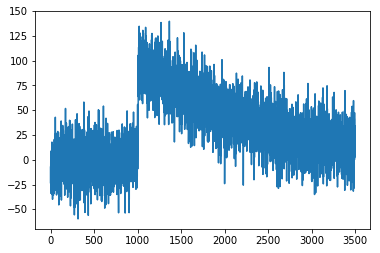

In [7]:
plt.plot(wfs[0])

## Filter Generation

In [8]:
@jit(nopython=True, parallel=True, nogil=True)
def fft_trapezoid(rise_time, flat_top , tau=1250):
    length = wavelen
    length = length+2*rise_time+flat_top;
    p = np.zeros(length)
    s = np.zeros(length)
    input2 = np.zeros(length)
    p[0] = 0.
    s[0] = 0.
    input2[0] = 0.;
    for i in range(1,length):
        input2[i] = s[i] = 0.;
    input2[1]=1.;
    tau = 1/(np.exp(1./tau)-1);
    for i in range(1,length):
        if i>=2*rise_time+flat_top:
            d = input2[i]-input2[i-rise_time]-input2[i-rise_time-flat_top]+input2[i-2*rise_time-flat_top]
        else:
            if i>=rise_time+flat_top:
                d = input2[i]-input2[i-rise_time]-input2[i-rise_time-flat_top]
            else:
                if i>=rise_time:
                    d = input2[i]-input2[i-rise_time]
                else:
                    d = input2[i];
        p[i] = p[i-1]+d;
        s[i] = s[i-1]+p[i]+tau*d;
    for i in range(length):
        s[i] = s[i]/(rise_time*tau);
    return s[:-(2*rise_time+flat_top)]

In [9]:
r = fft_trapezoid(100, 10)

In [10]:
%%cython
from libc.stdlib cimport malloc, free
cimport numpy as np
import numpy as np
np.import_array()

def fft_cusp(int rise_time, int flat_top, double tau=1250):
    
    cdef:

        int i;
        int wavelen=3500;
            
        short* inputWF = <short*> malloc(wavelen*sizeof(short));

        
        int filter_length = 2*rise_time+flat_top;
#        double *out = <double*>malloc(wavelen*sizeof(double)) #new double[wavelen];
        double *p0_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 1
        double *p1_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #1st-order polynomial, segment 1
        double *p2_1 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #2nd-order polynomial, segment 1
        double *p0_2 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 2
        double *p0_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #0th-order polynomial, segment 3
        double *p1_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #1st-order polynomial, segment 3
        double *p2_3 = <double*> malloc((wavelen+filter_length)*sizeof(double));# #2nd-order polynomial, segment 3
        double c0_1 = 0.5*(tau-0.5); #coefficient for p0_1
        double c1_1 = (tau-0.5); #coefficient for p1_1
        double c2_1 = 1.; #coefficient for p2_1
        double c0_2 = 0.5*rise_time*(rise_time+1.); #coefficient for p0_2
        double c0_3 = .5*(rise_time+rise_time*rise_time-(tau-0.5)-2.*rise_time*(tau-0.5)); #coefficient for p0_3
        double c1_3 = -1.-rise_time+(tau-0.5); #coefficient for p1_3
        double c2_3 = 1.; #coefficient for p2_3
    
    out = np.empty(wavelen+filter_length, dtype=np.float64)

    for i in range(1,wavelen):
        inputWF[i] = 0;
        inputWF[0] = 1;
    
    for i in range(filter_length): #(int i=0; i<filter_length; i++):
    
        p0_1[i] = p1_1[i] = p2_1[i] = p0_2[i] = p0_3[i] = p1_3[i] = p2_3[i] = 0.;
    
    for i in range(wavelen): #(int i=0; i<length; i++):

        p0_1[i+filter_length] = p0_1[i+filter_length-1] + inputWF[i] - (inputWF[i-rise_time] if i>=rise_time else 0);

        p1_1[i+filter_length] = p1_1[i+filter_length-1] + p0_1[i+filter_length] - (rise_time*inputWF[i-rise_time] if i>=rise_time else 0);
        p2_1[i+filter_length] = p2_1[i+filter_length-1] + p1_1[i+filter_length] - (0.5*rise_time*(rise_time+1)*inputWF[i-rise_time] if i>=rise_time else 0);

        p0_2[i+filter_length] = p0_2[i+filter_length-1] + (inputWF[i-rise_time] if i>=rise_time else 0) - (inputWF[i-rise_time-flat_top] if i>=(rise_time+flat_top) else 0);

        p0_3[i+filter_length] = p0_3[i+filter_length-1] + (inputWF[i-rise_time-flat_top] if i>=(rise_time+flat_top) else 0) - (inputWF[i-filter_length] if i>=filter_length else 0);
        p1_3[i+filter_length] = p1_3[i+filter_length-1] + p0_3[i+filter_length] - (rise_time*inputWF[i-filter_length] if i>=filter_length else 0);
        p2_3[i+filter_length] = p2_3[i+filter_length-1] + p1_3[i+filter_length] - (.5*rise_time*(rise_time+1)*inputWF[i-filter_length] if i>=filter_length else 0);

        out[i] = (c0_1*p0_1[i+filter_length]+c1_1*p1_1[i+filter_length]+c2_1*p2_1[i+filter_length]+c0_2*p0_2[i+filter_length]+c0_3*p0_3[i+filter_length]+c1_3*p1_3[i+filter_length]+c2_3*p2_3[i+filter_length])/(.5*rise_time*(rise_time+1.)*(tau-0.5));

    free(p0_1);
    free(p1_1);
    free(p2_1);
    free(p0_2);
    free(p0_3);
    free(p1_3);
    free(p2_3);

    return out[:-(flat_top+2*rise_time)];

In [11]:
def getFilter(name, params):
    FilterDict = {'trap':fft_trapezoid, 'cusp_top':fft_cusp}
    return np.fft.rfft(FilterDict[name](*params))

In [12]:
wf = dataGen(100, 900)

In [13]:
f = getFilter('cusp_top', (100,20))

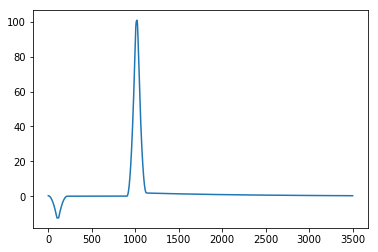

In [14]:
plt.plot(np.fft.irfft(np.fft.rfft(wf)*f))

### MWD based methods
Format algName(waveforms, arguments - expect 3)

In [15]:
f = getFilter('trap', [200,10])

In [16]:
@jit(nopython=True)
def thresholding(res, args):
    PERCENT = 0.75
    RISE, TOP = args
    
    maxVal = np.amax(res)*PERCENT
    
    crossing1 = -1; crossing2 = -1
    for i in range(800,wavelen-1):
        if (res[i]<maxVal and res[i+1] >= maxVal):
            crossing1 = i
            break
    for i in range(int(crossing1+TOP/2),wavelen-1):
        if (res[i]>maxVal and res[i+1] <= maxVal):
            crossing2 = i
            break
    t0 = (crossing1+crossing2)/2
    E = res[int(t0)]
    
    return E, t0

In [17]:
%time thresholding(np.fft.irfft(np.fft.rfft(wf)*f), (200., 10.))

CPU times: user 569 ms, sys: 182 µs, total: 569 ms
Wall time: 570 ms


(99.62411641426917, 1111.5)

In [18]:
def edgeLS(res, args):
    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,3,1,deriv=1)
    expected_slope = (np.amax(res)-np.std(res))/(rise)
    std_s = np.std(s[:-100])
        
    fall_range = [i for i in range(len(s)) if s[i]< -0.5*expected_slope]
    if len(fall_range)==0:
        return -1

    fall_range = np.arange(3500)[fall_range[0]:fall_range[-1]]
    
    a2, b2 = np.polyfit(fall_range, res[fall_range[0]:fall_range[-1]+1], 1) #LS(fall_range,res)
    
    t0 = -b2/a2 - 2*rise - top 
    E = res[int(t0 + rise + top/2)]
    return E, t0

In [19]:
edgeLS(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))

(99.68435284470947, 907.6060063378095)

In [20]:
def meanSlope(res, args):
    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,5,1,deriv=1)
    expected_slope = np.amax(res)/(rise-5)
    std_s = np.std(s[:-100])
    
    # fit to rise and fall
    left_shoulder = [i for i in range(len(s)) if s[i] > expected_slope-std_s]
    right_shoulder = [i for i in range(len(s)) if s[i]< -expected_slope+std_s]
    
    if len(left_shoulder)==0 or len(right_shoulder)==0:
        return -1
    t0 = (np.mean(left_shoulder)+np.mean(right_shoulder))/2 - rise - top/2
    E = res[int(t0+rise+top/2)]
    return E, t0

In [21]:
meanSlope(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))

(99.62411641426917, 906.75)

In [22]:
def shoulders(res, args): 
    rise, top = args
    # find range to look for
    s = scipy.signal.savgol_filter(res,5,1,deriv=1)
    expected_slope = np.amax(res)/(rise-5)
    std_s = np.std(s[:-100])
    
    # fit to rise and fall
    left_shoulder = [i for i in range(len(s)-2) if s[i] > expected_slope*0.5 and s[i+1] < expected_slope*0.5]
    right_shoulder = [i for i in range(len(s)-2) if s[i] < expected_slope*0.5 and s[i+1] > expected_slope*0.5]

    if len(left_shoulder)==0 or len(right_shoulder)==0:
        return -1

    t0 = (np.mean(left_shoulder)+np.mean(right_shoulder))/2 - rise/2 - top/2
    E = res[int(t0+rise+top/2)]
    return E, t0

In [23]:
shoulders(np.fft.irfft(np.fft.rfft(wf)*f), (200, 10))

(98.73667079911856, 901.0)

### Optimizing the threshold method - separate because it has a parameter in the method that needs optimized

In [24]:
%load_ext line_profiler

In [25]:
filterMethods = [thresholding, edgeLS, meanSlope, shoulders]
filterShapes = ['trap', 'cusp_top']
E = 1000.
noiseRMS = 20.
N = 10**4

In [26]:
riseRange = np.arange(1, 300, 10) # change these to be larger later
topRange = np.arange(0, 300, 10)

In [37]:
T0s = np.random.randint(900,1100, N)
WFs = NdataGen(N, E, T0s)

In [38]:
FilterMap = map(lambda x: getFilter(x[0][0], (x[0][1], x[0][2])), zip(product(filterShapes, riseRange, topRange)))
FilterMap = np.array(list(FilterMap)).reshape((len(filterShapes), len(riseRange), len(topRange), -1))

In [39]:
def runFilter(filterName, rise, top, f, data, T0s):
    N = len(data)
    wavelen = len(data[0])
    scratch = np.empty((N, 2))
   
    tmpX = np.fft.irfft(np.fft.rfft(data)*f)

    results = np.empty((len(filterMethods), 2, 2))
    
    for l, methodName in enumerate(filterMethods): # iterate through every method
        if methodName != thresholding and rise<20: # these filters fit slopes to rises. if there's no rise, there's nothing to fit
            results[l][1] = 10**2
            results[l][0] = 10**1
        else:
            for z in range(N):
                scratch[z] = methodName(tmpX[z], (rise, top))
                scratch[z][1] -= T0s[z]
            results[l][0][0] = np.mean(scratch[:,0])
            results[l][0][1] = np.std(scratch[:,0])
            results[l][1][0] = np.mean(scratch[:,1])
            results[l][1][1] = np.std(scratch[:,1])
            

    return results

In [42]:
p = Pool(processes=12)

In [43]:
%%time
results = p.starmap(lambda f, x: runFilter(x[0], x[1], x[2], f, WFs, T0s), zip(FilterMap.reshape(-1,1751), product(filterShapes, riseRange, topRange)))

CPU times: user 376 ms, sys: 81.9 ms, total: 458 ms
Wall time: 35.1 s


In [81]:
results = np.array(list(results)).reshape((len(filterShapes), len(riseRange), len(topRange), len(filterMethods), 2, 2))

In [82]:
results[1][-1][-1][0]

array([[1.00220143e+03, 1.80696772e+00],
       [4.42150000e+02, 3.90512484e-01]])

In [83]:
with open('totalResults', 'wb') as file:
    pickle.dump(results, file)

In [27]:
with open('totalResults', 'rb') as file:
    results = pickle.load(file)

In [28]:
results.shape

(2, 30, 30, 4, 2, 2)

In [29]:
x = results.copy()

In [32]:
for j, metric in enumerate(['E','T0']):
    for k, filterShape in enumerate(filterShapes):
        for i in range(len(filterMethods)):
            print(filterShape,metric,filterMethods[i])
            minIndex = np.unravel_index(np.argmin(results[k,:,:,i,j,1]),results[k,:,:,i,j,1].shape)
            while results[k][minIndex][i,j,1]==0:
                results[k][minIndex][i,j,1] = 10
                minIndex = np.unravel_index(np.argmin(results[k,:,:,i,j,1]),results[k,:,:,i,j,1].shape)
            #print('\tMin index: ', minIndex)
            print('\trise:',riseRange[minIndex[0]], 'top:', topRange[minIndex[1]])
            print('\tMin resolution', np.around(results[k][minIndex][i,j,1], 4))

trap E CPUDispatcher(<function thresholding at 0x7f185b08de18>)
	rise: 291 top: 40
	Min resolution 1.685
trap E <function edgeLS at 0x7f185b08dd90>
	rise: 291 top: 20
	Min resolution 1.6577
trap E <function meanSlope at 0x7f1852b8c510>
	rise: 291 top: 90
	Min resolution 1.6853
trap E <function shoulders at 0x7f18529dc510>
	rise: 291 top: 0
	Min resolution 1.8352
cusp_top E CPUDispatcher(<function thresholding at 0x7f185b08de18>)
	rise: 291 top: 40
	Min resolution 1.9144
cusp_top E <function edgeLS at 0x7f185b08dd90>
	rise: 51 top: 60
	Min resolution 4.5112
cusp_top E <function meanSlope at 0x7f1852b8c510>
	rise: 291 top: 40
	Min resolution 1.9123
cusp_top E <function shoulders at 0x7f18529dc510>
	rise: 41 top: 270
	Min resolution 6.295
trap T0 CPUDispatcher(<function thresholding at 0x7f185b08de18>)
	rise: 21 top: 0
	Min resolution 0.3574
trap T0 <function edgeLS at 0x7f185b08dd90>
	rise: 51 top: 50
	Min resolution 0.516
trap T0 <function meanSlope at 0x7f1852b8c510>
	rise: 291 top: 0
